# Goal: using the technical indicators provided in the data set of winning trades, predict the value of the target variable *tipo* (type of trade -buy/sell) 

## Import and data loading

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import time
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
from bokeh.models import DatetimeTickFormatter
from sklearn import model_selection, metrics, linear_model, datasets, feature_selection, tree, preprocessing
from sklearn.model_selection import train_test_split

In [4]:
df1 = pd.read_csv('data/EURUSD_15m_BID.csv', sep=",")
df2 = pd.read_csv('data/EURUSD_4h_profit.csv',sep=",")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## DF1 - Price values for EURUSD pair

 **Variable Definitions**
 
  - Open: price of the pair at the start of the time interval
  - High: highest price of the pair within the duration of the time interval
  - Low: minimum price of the pair within the duration of the time interval
  - Close: price of the pair at the end of the time interval
  - Volume: amount of trades that occured within the duration of the time interval

In [5]:
df1=df1.set_index("Time")
df1.index.names=[None]
df1.head()

,Open,High,Low,Close,Volume
2010-01-01 00:00,1.43283,1.43293,1.43224,1.43293,608600007.1
2010-01-01 00:15,1.43285,1.43295,1.43229,1.43275,535600003.2
2010-01-01 00:30,1.43280,1.43303,1.43239,1.43281,436299999.2
2010-01-01 00:45,1.43285,1.43294,1.43229,1.43276,614299997.3
2010-01-01 01:00,1.43287,1.43292,1.43206,1.43282,705300008.8


## DF2 - Winning trades for EURUSD pair

Variable Definitions

**RSI**: The relative strength index (RSI) is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset.
$$RSI_\text{step one}= 100− \left[ \frac{100}{1+\frac{\text {Average gain}}{\text {Average loss}}} \right]$$

$$RSI_\text{step two}= 100− \left[ \frac{100}{1+\frac{\text{Previous average gain}*13+ \text{Current gain} }{\text{Average average loss}*13+ \text{Current loss} }} \right]$$

**Stoch**: A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result.
$$%K = \left( \frac{C-L14}{H14-L14} \right) * 100 $$

**EMA**: An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points. The below equations refer to the slope of the EMA over the last 20, 50, 100, and 200 days.
$$EMA_{Today} = \left( \left( Value_{Today} * \frac{Smoothing}{1+Days} \right) \right) + EMA_{Yesterday}* \left( 1- \left( \frac{Smoothing}{1+Days} \right) \right)$$

ema20slope

ema50slope

ema100slope

ema200slope


**std**: Standard Deviation, a statistical measure of a stock's volatility.

**mom**: This indicator compares the price of any given instrument to the price over a selected number of preceding periods. It is calculated by taking the difference in today's closing price and the closing price of n periods before. When the indicator is above 100 it means the price is rising, below 100 is represents a downward trend.

$$MOM = \left( \frac{CP}{CPn} \right) * 100$$

where:
- C = most recent closing price
- L14 = lowest price traded of the previous 14 trading sessions
- H14 = highest price traded during the same 14-day period
- %K = current value of the stochastic indicator
**BB_up_percen**:

**cci**: Commodity Channel Index​ (CCI) is a momentum-based oscillator used to help determine when an investment vehicle is reaching a condition of being overbought or oversold. It is also used to assess price trend direction and strength.

$$CCI = \frac{\text{Typical Price} - MA}{.015*\text{Mean Deviation}}$$

$$\text{Typical Price} = \sum_{i=1}^{P} \frac {High + Low + Close}{3}$$

$$P = \text{Number of Periods}$$

$$MA = \text{Moving Average} = \frac {\sum_{i=1}^{P} \text{Typical Price}}{P}$$

$$\text{Mean Deviation} = \frac{\sum_{i=1}^{P} |\text{Typical Price} - \text{MA}|}{P}$$

**force**: The force index is a technical indicator that measures the amount of power used to move the price of an asset. The term and its formula were developed by psychologist and trader Alexander Elder and published in his 1993 book Trading for a Living. The force index uses price and volume to determine the amount of strength behind a price move.
$$\text{FI} \left( 1 \right) = \left( \text{CCP - PCP} \right) * \text{VFI} \left( 13 \right) = \text{13-Period EMA of FI} \left( 1 \right)$$

where:
- FI = Force Index
- CCP = current close price
- PCP = Prevjous close price
- VFI = Volume force index
- EMA = Exponential moving average

**macd**: The MACD (moving average convergence divergence) charts the difference between two exponential moving averages (a longer period EMA subtracted to a short period MA). The most common settings applied to MACD are 26 periods EMA and a 12 period EMA. The MACD is positive when the EMA(12) is above the EMA(26) indicating that the rate of change of the shorter period MA is higher than the longer period MA and this indicates positive momentum. On the other hand, it is negative when the EMA(12) is below the EMA(26), the rate of change of the shorter period MA is lower than the longer period MA indicating negative momentum.
$$MACD=EMA_{12} − EMA_{26}$$

**bearsPower**: The Bears Power oscillator was developed by Alexander Elder. It measures the difference between the lowest price and a 13-day Exponential Moving Average (EMA), plotted as a histogram. If the Bears Power indicator is below zero, it means sellers were able to drive price below the EMA. If the Bears Power indicator is above zero, it means buyers were able to keep the lowest price above the EMA
$$\text{Bears Power} = Low - EMA_{13}$$

**bullsPower**:
$$\text {Bulls Power} = High - EMA_{13}$$

**WPR**: Williams %R, also known as the Williams Percent Range, is a type of momentum indicator that moves between 0 and -100 and measures overbought and oversold levels. The Williams %R may be used to find entry and exit points in the market. The indicator is very similar to the Stochastic oscillator and is used in the same way.
$$\text{Williams Percentage Range} = \frac{\text{Highest High} - \text{Close}}{\text{Highest High}-\text{Lowest Low}}$$

**tipo**: type of operation (0=buy, 1=sell) this is our target variable

In [6]:
hour = df2['hour']
df2.drop(labels=['hour'], axis=1,inplace = True)
df2.insert(0, 'hour', hour)
day = df2['dayOfWeek']
df2.drop(labels=['dayOfWeek'],axis=1,inplace=True)
df2.insert(1,'dayOfWeek',day)
df2.head(10)

,hour,dayOfWeek,rsi1,rsi2,rsi3,rsi4,rsi5,rsi6,stoch1,stoch2,stoch3,stoch4,stoch5,stoch6,ema20Slope1,ema20Slope2,ema20Slope3,ema20Slope4,ema20Slope5,ema20Slope6,ema50Slope1,ema50Slope2,ema50Slope3,ema50Slope4,ema50Slope5,ema50Slope6,ema100Slope1,ema100Slope2,ema100Slope3,ema100Slope4,ema100Slope5,ema100Slope6,ema200Slope1,ema200Slope2,ema200Slope3,ema200Slope4,ema200Slope5,ema200Slope6,std1,std2,std3,std4,std5,std6,mom1,mom2,mom3,mom4,mom5,mom6,BB_up_percen1,BB_up_percen2,BB_up_percen3,BB_up_percen4,BB_up_percen5,BB_up_percen6,cci1,cci2,cci3,cci4,cci5,cci6,force1,force2,force3,force4,force5,force6,macd1,macd2,macd3,macd4,macd5,macd6,bearsPower1,bearsPower2,bearsPower3,bearsPower4,bearsPower5,bearsPower6,bullsPower1,bullsPower2,bullsPower3,bullsPower4,bullsPower5,bullsPower6,WPR1,WPR2,WPR3,WPR4,WPR5,WPR6,close1,close2,close3,close4,close5,close6,tipo
0,0,1,28.90,31.07,40.01,40.51,39.95,41.98,13.53,29.27,46.80,43.52,41.03,36.07,-0.00050,-0.00045,-0.00015,-0.00015,-0.00018,-0.00013,-0.00037,-0.00034,-0.00022,-0.00022,-0.00024,-0.00022,-0.00030,-0.00028,-0.00022,-0.00022,-0.00023,-0.00022,-1.33620,-0.00022,-0.00019,-0.00019,-0.00019,-0.00019,0.00189,0.00168,0.00158,0.00163,0.00166,0.00169,99.68,99.70,100.08,100.11,100.06,100.11,-0.10,-0.08,0.36,0.37,0.33,0.43,-225.44,-170.11,-33.39,-44.71,-33.96,-4.36,-1.58,-2.74,-0.31,0.55,0.16,0.17,-0.00187,-0.00164,-0.00142,-0.00146,-0.00151,-0.00154,-0.00385,-0.00412,-0.00119,-0.00242,-0.00121,-0.00089,-0.00277,0.00121,0.00130,0.00104,-0.00023,-0.00015,-100.00,-92.30,-74.34,-68.07,-65.93,-56.09,1.3132,1.3132,1.3132,1.3132,1.3132,1.3132,1
1,4,1,27.39,28.90,31.07,40.01,40.51,39.95,3.93,13.53,29.27,46.80,43.52,41.03,-0.00052,-0.00050,-0.00045,-0.00015,-0.00015,-0.00018,-0.00038,-0.00037,-0.00034,-0.00022,-0.00022,-0.00024,-0.00031,-0.00030,-0.00028,-0.00022,-0.00022,-0.00023,-1.33598,-0.00023,-0.00022,-0.00019,-0.00019,-0.00019,0.00217,0.00189,0.00168,0.00158,0.00163,0.00166,99.44,99.68,99.70,100.08,100.11,100.06,-0.07,-0.10,-0.08,0.36,0.37,0.33,-197.58,-225.44,-170.11,-33.39,-44.71,-33.96,-1.34,-1.58,-2.74,-0.31,0.55,0.16,-0.00208,-0.00187,-0.00164,-0.00142,-0.00146,-0.00151,-0.00407,-0.00385,-0.00412,-0.00119,-0.00242,-0.00121,-0.00298,-0.00277,0.00121,0.00130,0.00104,-0.00023,-98.76,-100.00,-92.30,-74.34,-68.07,-65.93,1.3125,1.3125,1.3125,1.3125,1.3125,1.3125,1
2,8,1,28.41,27.39,28.90,31.07,40.01,40.51,4.27,3.93,13.53,29.27,46.80,43.52,-0.00046,-0.00052,-0.00050,-0.00045,-0.00015,-0.00015,-0.00036,-0.00038,-0.00037,-0.00034,-0.00022,-0.00022,-0.00030,-0.00031,-0.00030,-0.00028,-0.00022,-0.00022,-1.33574,-0.00023,-0.00023,-0.00022,-0.00019,-0.00019,0.00242,0.00217,0.00189,0.00168,0.00158,0.00163,99.49,99.44,99.68,99.70,100.08,100.11,0.02,-0.07,-0.10,-0.08,0.36,0.37,-153.22,-197.58,-225.44,-170.11,-33.39,-44.71,-2.23,-1.34,-1.58,-2.74,-0.31,0.55,-0.00222,-0.00208,-0.00187,-0.00164,-0.00142,-0.00146,-0.00401,-0.00407,-0.00385,-0.00412,-0.00119,-0.00242,-0.00297,-0.00298,-0.00277,0.00121,0.00130,0.00104,-92.22,-98.76,-100.00,-92.30,-74.34,-68.07,1.3127,1.3127,1.3127,1.3127,1.3127,1.3127,1
3,12,1,34.48,28.41,27.39,28.90,31.07,40.01,12.99,4.27,3.93,13.53,29.27,46.80,-0.00030,-0.00046,-0.00052,-0.00050,-0.00045,-0.00015,-0.00030,-0.00036,-0.00038,-0.00037,-0.00034,-0.00022,-0.00027,-0.00030,-0.00031,-0.00030,-0.00028,-0.00022,-1.33551,-0.00023,-0.00023,-0.00023,-0.00022,-0.00019,0.00255,0.00242,0.00217,0.00189,0.00168,0.00158,99.42,99.49,99.44,99.68,99.70,100.08,0.17,0.02,-0.07,-0.10,-0.08,0.36,-94.61,-153.22,-197.58,-225.44,-170.11,-33.39,-4.60,-2.23,-1.34,-1.58,-2.74,-0.31,-0.00220,-0.00222,-0.00208,-0.00187,-0.00164,-0.00142,-0.00326,-0.00401,-0.00407,-0.00385,-0.00412,-0.00119,-0.00108,-0.00297,-0.00298,-0.00277,0.00121,0.00130,-80.81,-92.22,-98.76,-100.00,-92.30,-74.34,1.3138,1.3138,1.3138,1.3138,1.3138,1.3138,1
4,16,1,33.35,34.48,28.41,27.39,28.90,31.07,24.48,12.99,4.27,3.93,13.53,29.27,-0.00031,-0.00030,-0.00046,-0.00052,-0.00050,-0.00045,-0.00030,-0.00030,-0.00036,-0.00038,-0.00037,-0.00034,-0

In [7]:
df2.describe()

,hour,dayOfWeek,rsi1,rsi2,rsi3,rsi4,rsi5,rsi6,stoch1,stoch2,stoch3,stoch4,stoch5,stoch6,ema20Slope1,ema20Slope2,ema20Slope3,ema20Slope4,ema20Slope5,ema20Slope6,ema50Slope1,ema50Slope2,ema50Slope3,ema50Slope4,ema50Slope5,ema50Slope6,ema100Slope1,ema100Slope2,ema100Slope3,ema100Slope4,ema100Slope5,ema100Slope6,ema200Slope1,ema200Slope2,ema200Slope3,ema200Slope4,ema200Slope5,ema200Slope6,std1,std2,std3,std4,std5,std6,mom1,mom2,mom3,mom4,mom5,mom6,BB_up_percen1,BB_up_percen2,BB_up_percen3,BB_up_percen4,BB_up_percen5,BB_up_percen6,cci1,cci2,cci3,cci4,cci5,cci6,force1,force2,force3,force4,force5,force6,macd1,macd2,macd3,macd4,macd5,macd6,bearsPower1,bearsPower2,bearsPower3,bearsPower4,bearsPower5,bearsPower6,bullsPower1,bullsPower2,bullsPower3,bullsPower4,bullsPower5,bullsPower6,WPR1,WPR2,WPR3,WPR4,WPR5,WPR6,close1,close2,close3,close4,close5,close6,tipo
count,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000,4479.000000
mean,10.009377,2.993525,49.212367,49.218281,49.205930,49.192480,49.175113,49.173878,48.331369,48.359949,48.334941,48.322737,48.331170,48.306966,-0.000025,-0.000024,-0.000025,-0.000026,-0.000026,-0.000026,-0.000027,-0.000027,-0.000028,-0.000028,-0.000028,-0.000029,-0.000030,-0.000030,-0.000031,-0.000031,-0.000031,-0.000031,-1.127882,-0.000035,-0.000035,-0.000035,-0.000035,-0.000035,0.004519,0.004520,0.004520,0.004520,0.004519,0.004517,99.978453,99.977636,99.976225,99.975061,99.974961,99.974619,0.490118,0.491141,0.490813,0.490563,0.490219,0.490574,-1.643503,-1.258917,-1.445535,-1.495477,-1.661974,-1.421270,0.105323,0.109605,0.097332,0.059196,0.021277,0.043257,-0.000187,-0.000189,-0.000191,-0.000193,-0.000194,-0.000196,-0.001957,-0.001964,-0.001972,-0.001975,-0.001974,-0.001974,0.001762,0.001773,0.001764,0.001765,0.001760,0.001770,-52.238884,-52.163693,-52.173436,-52.211436,-52.215704,-52.205039,1.124408,1.124408,1.124408,1.124408,1.124408,1.124408,0.492967
std,6.828558,1.413804,13.057891,13.077693,13.094429,13.103938,13.109520,13.109564,24.638529,24.653636,24.645165,24.672112,24.708922,24.696689,0.000602,0.000603,0.000605,0.000605,0.000605,0.000605,0.000379,0.000380,0.000380,0.000380,0.000380,0.000380,0.000267,0.000267,0.000267,0.000267,0.000267,0.000267,0.061927,0.000193,0.000193,0.000193,0.000193,0.000193,0.002484,0.002485,0.002486,0.002485,0.002484,0.002483,0.900141,0.899777,0.901171,0.901832,0.901108,0.900663,0.337196,0.337825,0.338250,0.338369,0.339023,0.339606,110.947362,111.200039,111.099675,111.211091,111.673182,111.749064,18.481895,18.685709,18.778158,18.834913,18.743613,18.684330,0.003056,0.003056,0.003057,0.003056,0.003054,0.003052,0.004282,0.004293,0.004298,0.004307,0.004309,0.004305,0.004444,0.004455,0.004459,0.004463,0.004457,0.004455,29.177839,29.192386,29.223007,29.208164,29.221390,29.304558,0.057511,0.057511,0.057511,0.057511,0.057511,0.057511,0.500006
min,0.000000,0.000000,12.200000,12.200000,12.

if order hour open = 16<br><br>
rsi1 = rsi @ t-4 = rsi @ hour12<br>
rsi2 = rsi @ t-8 = rsi @ hour8<br>
rsi3 = rsi @ t-12 = rsi @ hour4<br>
rsi4 = rsi @ t-16 = rsi @ hour0<br>
rsi5 = rsi @ t-20 = rsi @ hour20 (previous day)<br>
rsi6 = rsi @ t-24 = rsi @ hour16 (previous day)

## Helper Functions

**Below I defined the following helper functions that I use throughout my analysis of these data sets. In this section you will find:**
 - drop_col(srs) - this function takes a series *srs* and deletes the columns with the titles found in the series
 - move_cols(srs)- this function takes a series *srs* and inserst the columes with the titles found in the series at the beginning of the row
 - inc_day2(x) - this function takes an iterator *x* and increments the days according to the hour and dayOfWeek column values in the dataframe
 - iso_interval(lst,num) - this function takes list *lst* and adds *num* in order to get the names of the "timeframed" variables
 - create_iso(df,num) - this function takes the base dataframe *df* and creates a dataframe with the subset of var *num*

In [8]:
def drop_col(srs,df):
    for x in srs:
        del df[x]

In [9]:
def move_cols(srs):
    for i in srs:
        #name = "my_"+i
        name = df2[i]
        df2.drop(labels=[i], axis=1,inplace = True)
        df2.insert(0, i, name)

In [10]:
def iso_interval(lst, num):
    result = []
    for i in lst:
        i = i + str(num)
        result.append(i)
    result.append("tipo")
    #print(result)
    return result

In [11]:
def create_iso(df,num):
    keep = ["rsi","stoch","ema20Slope","ema50Slope","ema100Slope","ema200Slope","std","mom","BB_up_percen","cci","force","macd","bearsPower","bullsPower","WPR","close"]
    #for combination of multiple time frames
        
    result = iso_interval(keep, num)
    df_temp = df.copy()
    column_names=list(df_temp)
    column_names_not = [i for i in column_names if i not in result]
    #print(column_names_not)
    drop_col(column_names_not,df_temp)
    return df_temp

In [12]:
def calc_change(metric,num,calc):
    denomenator = 1
    value = 0
    
    if calc == "avg":
        denomenator = 2
    elif calc == "slope":
        denomenator = 4*(num-1)
    else:
        raise InputError(calc,"calculation not accounted for")
        
    vari=[]
    numerator = 0
    for x in range(1,num+1):
        stor = "df2[" + (metric+str(x)) + "]"
        vari.append(stor)
    
    print(vari)
    numerator = sum(vari)
    
    value = numerator/denomenator
    
    return value

In [13]:
days = pd.bdate_range(start='8/4/2014', periods=6267, freq="4h")
trade_days = days[(days.dayofweek <= 4)]

In [14]:
#df2['time'] =(df2["hour"].astype(str)+":00:00")
#df2['my_date'] = pd.bdate_range(start='8/4/2014', end='8/3/2017', freq="B")

#this approach approximates the date time, but as you can see, there are some missing values
df2['my_time'] = trade_days

#date_series = ["time", "my_time"]
#move_cols(date_series)


##debug
df2.head(40)

,hour,dayOfWeek,rsi1,rsi2,rsi3,rsi4,rsi5,rsi6,stoch1,stoch2,stoch3,stoch4,stoch5,stoch6,ema20Slope1,ema20Slope2,ema20Slope3,ema20Slope4,ema20Slope5,ema20Slope6,ema50Slope1,ema50Slope2,ema50Slope3,ema50Slope4,ema50Slope5,ema50Slope6,ema100Slope1,ema100Slope2,ema100Slope3,ema100Slope4,ema100Slope5,ema100Slope6,ema200Slope1,ema200Slope2,ema200Slope3,ema200Slope4,ema200Slope5,ema200Slope6,std1,std2,std3,std4,std5,std6,mom1,mom2,mom3,mom4,mom5,mom6,BB_up_percen1,BB_up_percen2,BB_up_percen3,BB_up_percen4,BB_up_percen5,BB_up_percen6,cci1,cci2,cci3,cci4,cci5,cci6,force1,force2,force3,force4,force5,force6,macd1,macd2,macd3,macd4,macd5,macd6,bearsPower1,bearsPower2,bearsPower3,bearsPower4,bearsPower5,bearsPower6,bullsPower1,bullsPower2,bullsPower3,bullsPower4,bullsPower5,bullsPower6,WPR1,WPR2,WPR3,WPR4,WPR5,WPR6,close1,close2,close3,close4,close5,close6,tipo,my_time
0,0,1,28.90,31.07,40.01,40.51,39.95,41.98,13.53,29.27,46.80,43.52,41.03,36.07,-0.00050,-0.00045,-0.00015,-0.00015,-0.00018,-0.00013,-0.00037,-0.00034,-0.00022,-0.00022,-0.00024,-0.00022,-0.00030,-0.00028,-0.00022,-0.00022,-0.00023,-0.00022,-1.33620,-0.00022,-0.00019,-0.00019,-0.00019,-0.00019,0.00189,0.00168,0.00158,0.00163,0.00166,0.00169,99.68,99.70,100.08,100.11,100.06,100.11,-0.10,-0.08,0.36,0.37,0.33,0.43,-225.44,-170.11,-33.39,-44.71,-33.96,-4.36,-1.58,-2.74,-0.31,0.55,0.16,0.17,-0.00187,-0.00164,-0.00142,-0.00146,-0.00151,-0.00154,-0.00385,-0.00412,-0.00119,-0.00242,-0.00121,-0.00089,-0.00277,0.00121,0.00130,0.00104,-0.00023,-0.00015,-100.00,-92.30,-74.34,-68.07,-65.93,-56.09,1.3132,1.3132,1.3132,1.3132,1.3132,1.3132,1,2014-08-04 00:00:00
1,4,1,27.39,28.90,31.07,40.01,40.51,39.95,3.93,13.53,29.27,46.80,43.52,41.03,-0.00052,-0.00050,-0.00045,-0.00015,-0.00015,-0.00018,-0.00038,-0.00037,-0.00034,-0.00022,-0.00022,-0.00024,-0.00031,-0.00030,-0.00028,-0.00022,-0.00022,-0.00023,-1.33598,-0.00023,-0.00022,-0.00019,-0.00019,-0.00019,0.00217,0.00189,0.00168,0.00158,0.00163,0.00166,99.44,99.68,99.70,100.08,100.11,100.06,-0.07,-0.10,-0.08,0.36,0.37,0.33,-197.58,-225.44,-170.11,-33.39,-44.71,-33.96,-1.34,-1.58,-2.74,-0.31,0.55,0.16,-0.00208,-0.00187,-0.00164,-0.00142,-0.00146,-0.00151,-0.00407,-0.00385,-0.00412,-0.00119,-0.00242,-0.00121,-0.00298,-0.00277,0.00121,0.00130,0.00104,-0.00023,-98.76,-100.00,-92.30,-74.34,-68.07,-65.93,1.3125,1.3125,1.3125,1.3125,1.3125,1.3125,1,2014-08-04 04:00:00
2,8,1,28.41,27.39,28.90,31.07,40.01,40.51,4.27,3.93,13.53,29.27,46.80,43.52,-0.00046,-0.00052,-0.00050,-0.00045,-0.00015,-0.00015,-0.00036,-0.00038,-0.00037,-0.00034,-0.00022,-0.00022,-0.00030,-0.00031,-0.00030,-0.00028,-0.00022,-0.00022,-1.33574,-0.00023,-0.00023,-0.00022,-0.00019,-0.00019,0.00242,0.00217,0.00189,0.00168,0.00158,0.00163,99.49,99.44,99.68,99.70,100.08,100.11,0.02,-0.07,-0.10,-0.08,0.36,0.37,-153.22,-197.58,-225.44,-170.11,-33.39,-44.71,-2.23,-1.34,-1.58,-2.74,-0.31,0.55,-0.00222,-0.00208,-0.00187,-0.00164,-0.00142,-0.00146,-0.00401,-0.00407,-0.00385,-0.00412,-0.00119,-0.00242,-0.00297,-0.00298,-0.00277,0.00121,0.00130,0.00104,-92.22,-98.76,-100.00,-92.30,-74.34,-68.07,1.3127,1.3127,1.3127,1.3127,1.3127,1.3127,1,2014-08-04 08:00:00
3,12,1,34.48,28.41,27.39,28.90,31.07,40.01,12.99,4.27,3.93,13.53,29.27,46.80,-0.00030,-0.00046,-0.00052,-0.00050,-0.00045,-0.00015,-0.00030,-0.00036,-0.00038,-0.00037,-0.00034,-0.00022,-0.00027,-0.00030,-0.00031,-0.00030,-0.00028,-0.00022,-1.33551,-0.00023,-0.00023,-0.00023,-0.00022,-0.00019,0.00255,0.00242,0.00217,0.00189,0.00168,0.00158,99.42,99.49,99.44,99.68,99.70,100.08,0.17,0.02,-0.07,-0.10,-0.08,0.36,-94.61,-153.22,-197.58,-225.44,-170.11,-33.39,-4.60,-2.23,-1.34,-1.58,-2.74,-0.31,-0.00220,-0.00222,-0.00208,-0.00187,-0.00164,-0.00142,-0.00326,-0.00401,-0.00407,-0.00385,-0.00412,-0.00119,-0.00108,-0.00297,-0.00298,-0.00277,0.00121,0.00130,-80.81,-92.22,-98.76,-100.00,-92.30,-74.34,1.3138,1.3138,1.3138,1.3138,1.3138,1.3138,1,2014-08-04 12:00:00
4,16,1,33.35,34.48,28.41,27.39,28.90,31.07,24.48,12.99,4.27,3.93,13.53,29.27,-0.00031,-0.00030,-0.0

In [15]:
type(df2['my_time'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [16]:
#here we calculate the "acceleration of RSI over the time frame between t-4 and t-8hr"
df2['rsi_acc']=(df2['rsi2']-df2['rsi1'])/4
#calc_change('rsi',2,"slope")
df2['stoch_acc']=(df2['stoch2']-df2['stoch1'])/4
df2['ema20slope_acc']=(df2['ema20Slope2']-df2['ema20Slope1'])/4
df2['ema50slope_acc']=(df2['ema50Slope2']-df2['ema50Slope1'])/4
df2['ema100slope_acc']=(df2['ema100Slope2']-df2['ema100Slope1'])/4
df2['ema200slope_acc']=(df2['ema200Slope2']-df2['ema200Slope1'])/4
df2['mom_acc']=(df2['mom2']-df2['mom1'])/4
df2['cci_acc']=(df2['cci2']-df2['cci1'])/4
df2['macd_acc']=(df2['macd2']-df2['macd1'])/4
move_cols(['rsi_acc','stoch_acc','ema20slope_acc','ema50slope_acc','ema100slope_acc','ema200slope_acc','mom_acc','cci_acc','macd_acc'])

In [17]:
df2.head(50)

,macd_acc,cci_acc,mom_acc,ema200slope_acc,ema100slope_acc,ema50slope_acc,ema20slope_acc,stoch_acc,rsi_acc,hour,dayOfWeek,rsi1,rsi2,rsi3,rsi4,rsi5,rsi6,stoch1,stoch2,stoch3,stoch4,stoch5,stoch6,ema20Slope1,ema20Slope2,ema20Slope3,ema20Slope4,ema20Slope5,ema20Slope6,ema50Slope1,ema50Slope2,ema50Slope3,ema50Slope4,ema50Slope5,ema50Slope6,ema100Slope1,ema100Slope2,ema100Slope3,ema100Slope4,ema100Slope5,ema100Slope6,ema200Slope1,ema200Slope2,ema200Slope3,ema200Slope4,ema200Slope5,ema200Slope6,std1,std2,std3,std4,std5,std6,mom1,mom2,mom3,mom4,mom5,mom6,BB_up_percen1,BB_up_percen2,BB_up_percen3,BB_up_percen4,BB_up_percen5,BB_up_percen6,cci1,cci2,cci3,cci4,cci5,cci6,force1,force2,force3,force4,force5,force6,macd1,macd2,macd3,macd4,macd5,macd6,bearsPower1,bearsPower2,bearsPower3,bearsPower4,bearsPower5,bearsPower6,bullsPower1,bullsPower2,bullsPower3,bullsPower4,bullsPower5,bullsPower6,WPR1,WPR2,WPR3,WPR4,WPR5,WPR6,close1,close2,close3,close4,close5,close6,tipo,my_time
0,0.000057,13.8325,0.0050,0.333995,0.000005,0.000008,0.000013,3.9350,0.5425,0,1,28.90,31.07,40.01,40.51,39.95,41.98,13.53,29.27,46.80,43.52,41.03,36.07,-0.00050,-0.00045,-0.00015,-0.00015,-0.00018,-0.00013,-0.00037,-0.00034,-0.00022,-0.00022,-0.00024,-0.00022,-0.00030,-0.00028,-0.00022,-0.00022,-0.00023,-0.00022,-1.33620,-0.00022,-0.00019,-0.00019,-0.00019,-0.00019,0.00189,0.00168,0.00158,0.00163,0.00166,0.00169,99.68,99.70,100.08,100.11,100.06,100.11,-0.10,-0.08,0.36,0.37,0.33,0.43,-225.44,-170.11,-33.39,-44.71,-33.96,-4.36,-1.58,-2.74,-0.31,0.55,0.16,0.17,-0.00187,-0.00164,-0.00142,-0.00146,-0.00151,-0.00154,-0.00385,-0.00412,-0.00119,-0.00242,-0.00121,-0.00089,-0.00277,0.00121,0.00130,0.00104,-0.00023,-0.00015,-100.00,-92.30,-74.34,-68.07,-65.93,-56.09,1.3132,1.3132,1.3132,1.3132,1.3132,1.3132,1,2014-08-04 00:00:00
1,0.000053,-6.9650,0.0600,0.333937,0.000003,0.000002,0.000005,2.4000,0.3775,4,1,27.39,28.90,31.07,40.01,40.51,39.95,3.93,13.53,29.27,46.80,43.52,41.03,-0.00052,-0.00050,-0.00045,-0.00015,-0.00015,-0.00018,-0.00038,-0.00037,-0.00034,-0.00022,-0.00022,-0.00024,-0.00031,-0.00030,-0.00028,-0.00022,-0.00022,-0.00023,-1.33598,-0.00023,-0.00022,-0.00019,-0.00019,-0.00019,0.00217,0.00189,0.00168,0.00158,0.00163,0.00166,99.44,99.68,99.70,100.08,100.11,100.06,-0.07,-0.10,-0.08,0.36,0.37,0.33,-197.58,-225.44,-170.11,-33.39,-44.71,-33.96,-1.34,-1.58,-2.74,-0.31,0.55,0.16,-0.00208,-0.00187,-0.00164,-0.00142,-0.00146,-0.00151,-0.00407,-0.00385,-0.00412,-0.00119,-0.00242,-0.00121,-0.00298,-0.00277,0.00121,0.00130,0.00104,-0.00023,-98.76,-100.00,-92.30,-74.34,-68.07,-65.93,1.3125,1.3125,1.3125,1.3125,1.3125,1.3125,1,2014-08-04 04:00:00
2,0.000035,-11.0900,-0.0125,0.333877,-0.000003,-0.000005,-0.000015,-0.0850,-0.2550,8,1,28.41,27.39,28.90,31.07,40.01,40.51,4.27,3.93,13.53,29.27,46.80,43.52,-0.00046,-0.00052,-0.00050,-0.00045,-0.00015,-0.00015,-0.00036,-0.00038,-0.00037,-0.00034,-0.00022,-0.00022,-0.00030,-0.00031,-0.00030,-0.00028,-0.00022,-0.00022,-1.33574,-0.00023,-0.00023,-0.00022,-0.00019,-0.00019,0.00242,0.00217,0.00189,0.00168,0.00158,0.00163,99.49,99.44,99.68,99.70,100.08,100.11,0.02,-0.07,-0.10,-0.08,0.36,0.37,-153.22,-197.58,-225.44,-170.11,-33.39,-44.71,-2.23,-1.34,-1.58,-2.74,-0.31,0.55,-0.00222,-0.00208,-0.00187,-0.00164,-0.00142,-0.00146,-0.00401,-0.00407,-0.00385,-0.00412,-0.00119,-0.00242,-0.00297,-0.00298,-0.00277,0.00121,0.00130,0.00104,-92.22,-98.76,-100.00,-92.30,-74.34,-68.07,1.3127,1.3127,1.3127,1.3127,1.3127,1.3127,1,2014-08-04 08:00:00
3,-0.000005,-14.6525,0.0175,0.333820,-0.000007,-0.000015,-0.000040,-2.1800,-1.5175,12,1,34.48,28.41,27.39,28.90,31.07,40.01,12.99,4.27,3.93,13.53,29.27,46.80,-0.00030,-0.00046,-0.00052,-0.00050,-0.00045,-0.00015,-0.00030,-0.00036,-0.00038,-0.00037,-0.00034,-0.00022,-0.00027,-0.00030,-0.00031,-0.00030,-0.00028,-0.00022,-1.33551,-0.00023,-0.00023,-0.00023,-0.00022,-0.00019,0.00255,0.00242,0.00217,0.00189,0.00168,0.00158,99.42,99.49,99.44,99.68,99.70,100.08,0.17,0.02,-0.07,-0.10,-0.08,0.36,-94.61,-153.22,-197.58,-225.44,-1

In [21]:
df_buy = df2[df2['tipo']==0]
df_sell = df2[df2['tipo']==1]

df_buy_acc = df_buy.loc[:,'macd_acc':'rsi_acc']
df_sell_acc = df_sell.loc[:,'macd_acc':'rsi_acc']

In [22]:
df_buy_acc.describe()

,macd_acc,cci_acc,mom_acc,ema200slope_acc,ema100slope_acc,ema50slope_acc,ema20slope_acc,stoch_acc,rsi_acc
count,2271.000000,2271.000000,2271.000000,2271.000000,2.271000e+03,2.271000e+03,2.271000e+03,2271.000000,2271.000000
mean,-0.000001,-0.187354,-0.001791,0.281257,-1.882431e-07,-3.654778e-07,-8.586526e-07,-0.050615,-0.012962
std,0.000085,15.417809,0.089563,0.014753,1.380542e-05,2.743853e-05,6.746916e-05,2.973654,1.190636
min,-0.000520,-133.065000,-0.780000,0.264167,-1.325000e-04,-2.600000e-04,-6.375000e-04,-14.077500,-8.805000
25%,-0.000050,-7.070000,-0.042500,0.271883,-7.500000e-06,-1.250000e-05,-3.250000e-05,-1.945000,-0.645000
50%,-0.000002,0.220000,-0.002500,0.277993,0.000000e+00,0.000000e+00,0.000000e+00,-0.067500,0.017500
75%,0.000046,7.251250,0.042500,0.281643,5.000000e-06,1.250000e-05,3.000000e-05,1.822500,0.612500
max,0.000782,132.197500,0.700000,0.332665,1.650000e-04,3.225000e-04,7.750000e-04,9.597500,7.525000


In [23]:
df_sell_acc.describe()

,macd_acc,cci_acc,mom_acc,ema200slope_acc,ema100slope_acc,ema50slope_acc,ema20slope_acc,stoch_acc,rsi_acc
count,2.208000e+03,2208.000000,2208.000000,2208.000000,2.208000e+03,2.208000e+03,2.208000e+03,2208.000000,2208.000000
mean,4.721467e-07,0.387736,0.001428,0.282687,1.528533e-07,3.396739e-07,9.182518e-07,0.066553,0.016332
std,8.958891e-05,15.452993,0.086555,0.016134,1.378034e-05,2.740852e-05,6.766502e-05,2.986585,1.222686
min,-4.725000e-04,-116.670000,-0.627500,0.264185,-1.375000e-04,-2.700000e-04,-6.650000e-04,-10.460000,-8.122500
25%,-4.750000e-05,-7.073125,-0.042500,0.273479,-7.500000e-06,-1.250000e-05,-3.250000e-05,-1.891250,-0.636250
50%,-2.500000e-06,0.001250,0.000000,0.278544,0.000000e+00,0.000000e+00,0.000000e+00,0.117500,0.008750
75%,5.250000e-05,7.363125,0.047500,0.283083,5.000000e-06,1.250000e-05,3.000000e-05,1.913750,0.630000
max,3.950000e-04,140.942500,0.437500,0.333995,8.500000e-05,1.725000e-04,4.175000e-04,12.280000,7.425000


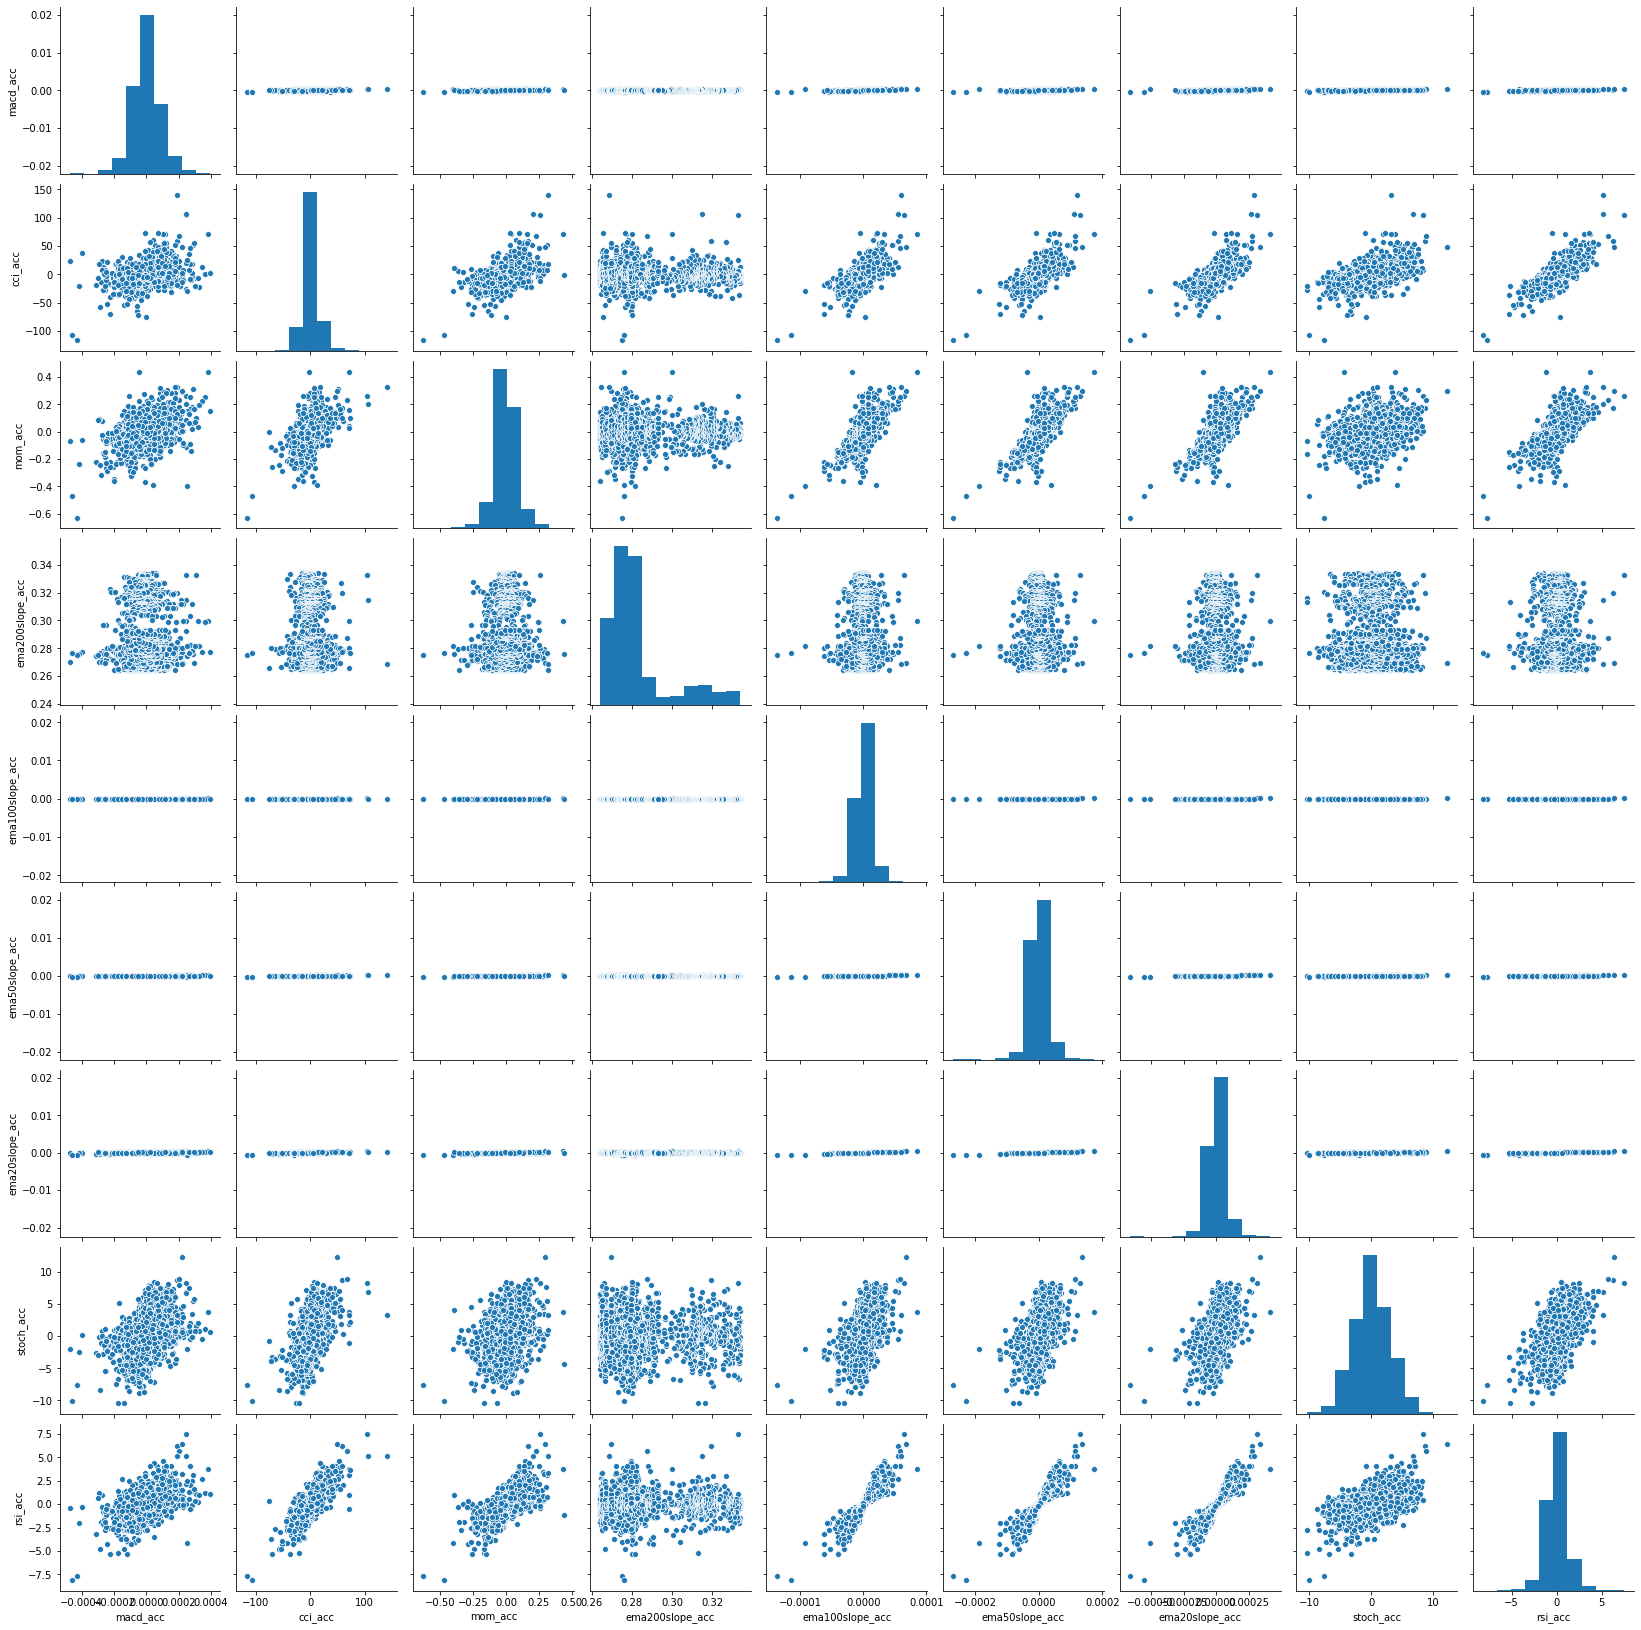

In [24]:
sns.pairplot(df_sell_acc)

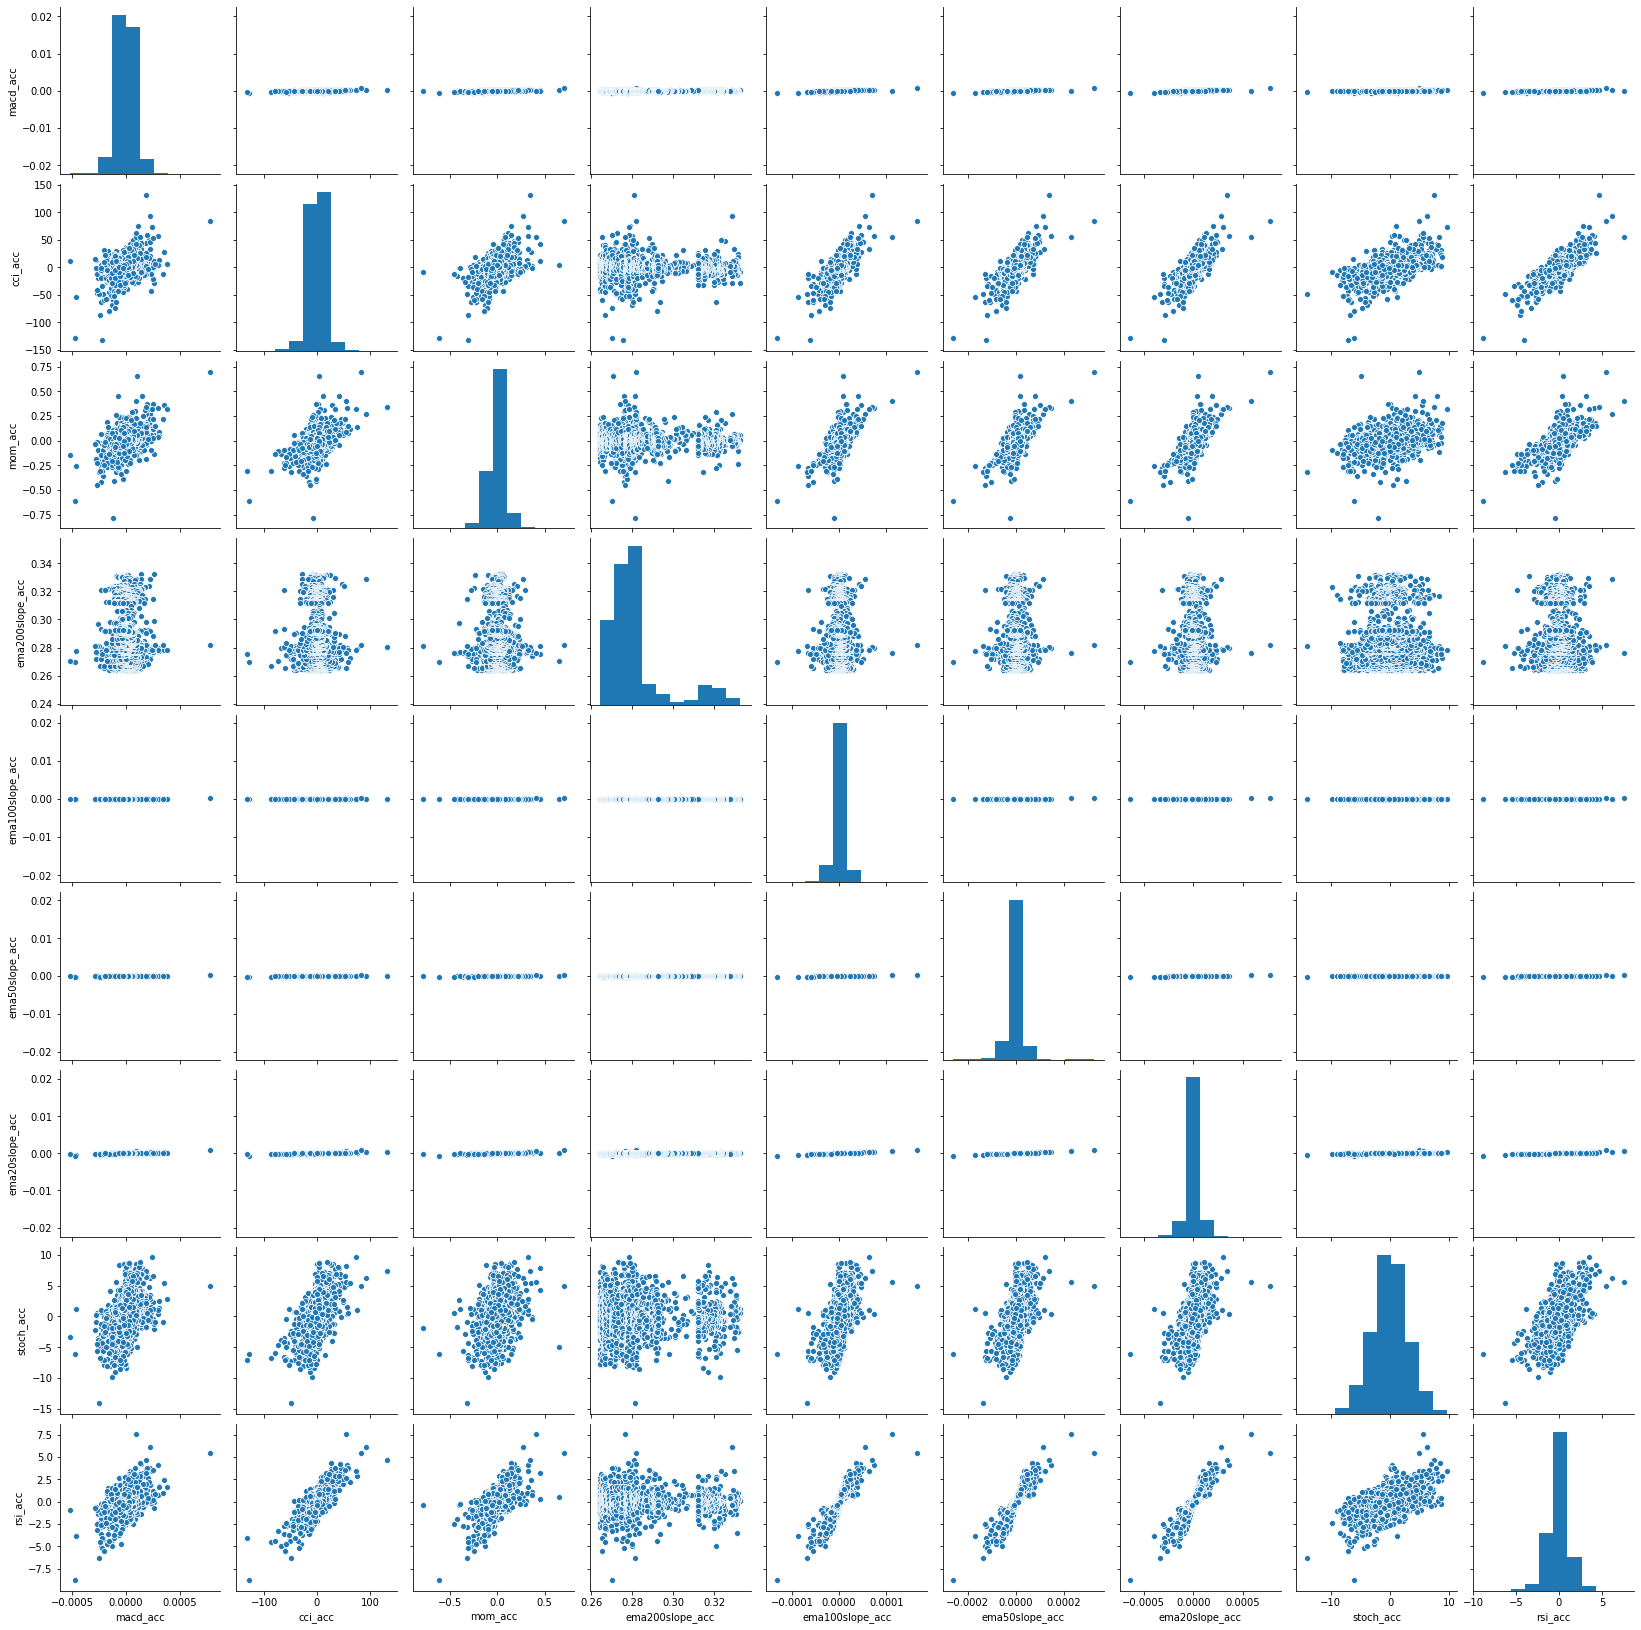

In [25]:
sns.pairplot(df_buy_acc)

In [ ]:
len(df_buy['macd_acc'])

In [ ]:
len(df_sell['macd_acc'])

In [ ]:
df_buy=df_buy[(df_buy['macd_acc']<.0004) & (df_buy['macd_acc']>-.0004)]

In [ ]:
plt.figure(figsize=(15,12))
x = range(len(df_buy))
y = df_buy['macd_acc']
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, 'o', color='black')
plt.plot(x, m*x+b)


In [ ]:
plt.figure(figsize=(15,12))
x = range(len(df_sell))
y = df_sell['macd_acc']
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, 'o', color='black')
plt.plot(x, m*x+b)

In [ ]:
plt.figure(figsize=(15,12))
x = df_sell['macd_acc']
y = df_buy['macd_acc']
m, b = np.polyfit(x, y, 1)

plt.plot(x, y, 'o', color='black')
plt.plot(x, m*x+b)

In [ ]:
drop_col(['time','hour','dayOfWeek'],df2)

In [ ]:
##this is for creating a time series, which we dont want to do at this point
#df2=df2.set_index("dt")
#df2.index.names=[None]

#debug
#df2.head()

In [ ]:
df2_tminus4 = create_iso(df2,1)

In [ ]:
df2_tminus4.describe()

In [ ]:
##Standard Scaler nor MinMaxScaler isn't appropriate for this set
##Potentially a % change of each metric over the given time frames
#scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()
#df2_tminus4[df2_tminus4.columns] = scaler.fit_transform(df2_tminus4[df2_tminus4.columns])
df2_tminus4.head(10)

In [ ]:
sns.pairplot(df2_tminus4)

In [ ]:
plt.subplots(figsize=(15,15))
sns.heatmap(df2_tminus4.corr(),annot=True,cmap="YlGnBu" )

In [ ]:
df2_tminus8 = create_iso(df2,2)

In [ ]:
##debug
#df2_tminus8.head()

In [ ]:
sns.pairplot(df2_tminus8)

In [ ]:
plt.subplots(figsize=(15,15))
sns.heatmap(df2_tminus8.corr(),annot=True, cmap="YlGnBu")

In [ ]:
df2_tminus12 = create_iso(df2,3)

In [ ]:
##debug
#df2_tminus12.head()

In [ ]:
sns.pairplot(df2_tminus12)

In [ ]:
plt.subplots(figsize=(15,15))
sns.heatmap(df2_tminus12.corr(),annot=True,cmap="YlGnBu")

In [ ]:
df2_tminus16 = create_iso(df2,4)

In [ ]:
##debug
#df2_tminus16.head()

In [ ]:
sns.pairplot(df2_tminus16)

In [ ]:
plt.subplots(figsize=(15,15))
sns.heatmap(df2_tminus16.corr(),annot=True, cmap="YlGnBu")

In [ ]:
df2_tminus20 = create_iso(df2,5)

In [ ]:
df2_tminus20.head()

In [ ]:
sns.pairplot(df2_tminus20)

In [ ]:
plt.subplots(figsize=(15,15))
sns.heatmap(df2_tminus20.corr(),annot=True,cmap="YlGnBu")

In [ ]:
 df2_tminus24 = create_iso(df2,6)

In [ ]:
df2_tminus24.head() 

In [ ]:
sns.pairplot(df2_tminus24)

In [ ]:
plt.subplots(figsize=(15,15))
sns.heatmap(df2_tminus24.corr(),annot=True,cmap="YlGnBu")

In [ ]:
ema200_corr_avg = (-.073+-.072+-.071+-.07+-.069)/5
print(ema200_corr_avg)

Logistic Regression

In [ ]:
train, test = train_test_split(df2_tminus4, test_size=0.2)

In [ ]:
X=train[['rsi1','macd1','ema20Slope1','ema50Slope1','ema100Slope1','ema200Slope1','bearsPower1','bullsPower1','WPR1']]

In [ ]:
y = train['tipo']

In [ ]:
bt_model = linear_model.LogisticRegression(solver='liblinear')
bt_model.fit(X,y)

In [ ]:
Xnew = test[['rsi1','macd1','ema20Slope1','ema50Slope1','ema100Slope1','ema200Slope1','bearsPower1','bullsPower1','WPR1']]

In [ ]:
test_action = bt_model.predict(Xnew)
print(metrics.accuracy_score(test['tipo'],test_action))

In [ ]:
print("intercept")
beta_0 = bt_model.intercept_[0]
print(beta_0)
beta_1 = bt_model.coef_[0][0]
beta_2 = bt_model.coef_[0][1]
beta_3 = bt_model.coef_[0][2]
beta_4 = bt_model.coef_[0][3]
beta_5 = bt_model.coef_[0][4]
beta_6 = bt_model.coef_[0][5]
beta_7 = bt_model.coef_[0][6]
beta_8 = bt_model.coef_[0][7]
beta_9 = bt_model.coef_[0][8]
print("coefs")
print(beta_1)
print(beta_2)
print(beta_3)
print(beta_4)
print(beta_5)
print(beta_6)
print(beta_7)
print(beta_8)
print(beta_9)

In [ ]:
bt_model.predict_proba(Xnew)[:,1]

In [ ]:
bt_model.score(X,y)

## testing different input

In [ ]:
X2=train[['close1','std1','macd1','force1','WPR1','bullsPower1']]

In [ ]:
bt_model2 = linear_model.LogisticRegression(solver='liblinear')
bt_model2.fit(X2,y)

In [ ]:
Xnew2 = test[['close1','std1','macd1','force1','WPR1','bullsPower1']]

In [ ]:
test_action2 = bt_model2.predict(Xnew2)
print(metrics.accuracy_score(test['tipo'],test_action2))

In [ ]:
bt_model2.score(X2,y)

## Linear Regression with all inputs

In [ ]:
cols = list(df2_tminus4.columns)

In [ ]:
X3=train[cols]

In [ ]:
new_X3 = X3.drop(['tipo'],axis=1)

In [ ]:
new_X3.head()

In [ ]:
bt_model3 = linear_model.LogisticRegression(solver='liblinear')
bt_model3.fit(new_X3,y)

In [ ]:
Xnew3 = test[cols].drop(['tipo'],axis=1)

In [ ]:
test_action3 = bt_model3.predict(Xnew3)
print(metrics.accuracy_score(test['tipo'],test_action3))

In [ ]:
bt_model3.score(new_X3,y)

## Decision Tree Classifier

In [ ]:
df2_tminus4.head()

In [ ]:
#removing some of the "noise" - redundant or non-correlated indicators
drop_col(['std1','BB_up_percen1','bearsPower1','bullsPower1','force1','WPR1'],df2_tminus4)

In [ ]:
df2_tminus4.head()

In [ ]:
actions = tree.DecisionTreeClassifier()
train_tree, test_tree = train_test_split(df2_tminus4, test_size=0.2)

In [ ]:
train_tree2 = train_tree.drop(['tipo'],axis=1)

In [ ]:
test_tree2 = test_tree.drop(['tipo'],axis=1)

In [ ]:
actions.fit(train_tree2, train_tree['tipo'])

In [ ]:
test_action = actions.predict(test_tree2)
print(metrics.accuracy_score(test_tree['tipo'],test_action))

we achieve a prediction accuracy of **78%** using the Decision Tree Classification model !!

In [ ]:
conf_matrix = metrics.confusion_matrix(test_tree['tipo'],test_action)
conf_matrix

Below are the results of our Decision Tree Classifier on our test set:

|                       |  Predicted Sell|  Predicted Buy |
|---------------------:|:---------------------:|:---------------:|
| **Actual Sell** |           358           |       101         |    0              |    0              |
| **Actual Buy**      |            96          |        341        |    
